# Federated Learning exmple Using Keras
in this tutorial we are going to study FL API of tensorflow.

## Needed libraries

we should install some developing libs as it's not available on master branch(21 December 2020)

In [1]:
import sys
from platform import uname
import os


if "google.colab" in sys.modules:
    
    # can causes a duplicate tensorboard install, leading to errors.
    !pip uninstall --yes tensorboard tb-nightly
    !pip install  --upgrade tensorflow_federated_nightly
    !pip install  tb-nightly  # or tensorboard, but not both
else:
    !pip uninstall --yes tb-nightly
    !pip install tensorboard
    
!pip install  --upgrade nest_asyncio


%load_ext tensorboard


In [2]:
if (uname())[0] !='Windows':
    !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

![Diagram](tff5.svg)

Before we start implementing an example let's survey tensorflow FL API

## Overview
we are going to study interfaces that facilitate federated learning tasks, such as federated training or evaluation with existing machine learning models implemented in TensorFlow.

The interfaces offered by this API consist of the following three key parts:
* **Models.** Classes and helper functions that allow you to wrap your existing models for use with TFF. Wrapping a model can be as simple as calling a single wrapping function (e.g., `tff.learning.from_keras_model`, or defining a subclass of the tff.learning.Model interface for full customizability.
    - It means you don't have to make new model for FL, you may just simply use `tff.learning.from_keras_model` to convert keras model into tff.learning.Model
    
    
* **Federated Computation Builders.** Helper functions that construct federated computations for training or evaluation, using your existing models.
    - This functions will be needed in order to simulate Avraging process on All the system(including FL server and devices)
    
    
* **Datasets.** Canned collections of data that you can download and access in Python for use in simulating federated learning scenarios. Although federated learning is designed for use with decentralized data that cannot be simply downloaded at a centralized location, at the research and development stages it is often convenient to conduct initial experiments using data that can be downloaded and manipulated locally, especially for developers who might be new to the approach.



In our system we have two aggregations:

1. **Local aggregation.** This level of aggregation refers to aggregation across multiple batches of examples owned by an individual client. It applies to both the model parameters (variables), which continue to sequentially evolve as the model is locally trained, as well as the statistics you compute (such as average loss, accuracy, and other metrics), which your model will again update locally as it iterates over each individual client's local data stream.

 Performing aggregation at this level is the responsibility of your model code, and is accomplished using standard TensorFlow constructs.

 The general structure of processing is as follows:

 * The model first constructs tf.Variables to hold aggregates, such as the number of batches or the number of examples processed, the sum of per-batch or per-example losses, etc.

 * TFF invokes the forward_pass method on your Model multiple times, sequentially over subsequent batches of client data, which allows you to update the variables holding various aggregates as a side effect.

 * Finally, TFF invokes the report_local_outputs method on your Model to allow your model to compile all the summary statistics it collected into a compact set of metrics to be exported by the client. This is where your model code may, for example, divide the sum of losses by the number of examples processed to export the average loss, etc.

2. **Federated aggregation.** This level of aggregation refers to aggregation across multiple clients (devices) in the system. Again, it applies to both the model parameters (variables), which are being averaged across clients, as well as the metrics your model exported as a result of local aggregation.

 Performing aggregation at this level is the responsibility of TFF. As a model creator, however, you can control this process (more on this below).

 The general structure of processing is as follows:

  * The initial model, and any parameters required for training, are distributed by a server to a subset of clients that will participate in a round of training or evaluation.

  * On each client, independently and in parallel, your model code is invoked repeatedly on a stream of local data batches to produce a new set of model parameters (when training), and a new set of local metrics, as described above (this is local aggregation).

  * TFF runs a distributed aggregation protocol to accumulate and aggregate the model parameters and locally exported metrics across the system. This logic is expressed in a declarative manner using TFF's own federated computation language (not in TensorFlow), in the Model's federated_output_computation.

## Abstract interfaces
This basic constructor + metadata interface is represented by the interface `tff.learning.Model`, as follows:

* The constructor, `forward_pass`, and `report_local_outputs` methods should construct model variables, forward pass, and statistics you wish to report, correspondingly. The TensorFlow constructed by those methods must be serializable.

* The `input_spec` property, as well as the 3 properties that return subsets of your trainable, non-trainable, and local variables represent the metadata. TFF uses this information to determine how to connect parts of your model to the federated optimization algorithms, and to define internal type signatures to assist in verifying the correctness of the constructed system (so that your model cannot be instantiated over data that does not match what the model is designed to consume).

In addition, the abstract interface `tff.learning.Model` exposes a property `federated_output_computation` that, together with the `report_local_outputs` property mentioned earlier, allows you to control the process of aggregating summary statistics.

## Converters for Keras
Nearly all the information that's required by TFF can be derived by calling `tf.keras` interfaces, so if you have a Keras model, you can rely on tff.learning.from_keras_model to construct a tff.learning.Model.
**Note:** TFF still wants you to provide a **constructor** \[not a instance of model\] - a no-argument model function such as the following:
```python
def model_fn():
keras_model = ...
return tff.learning.from_keras_model(keras_model, sample_batch, loss=...)
```
In addition to the model itself, you supply a sample batch of data which TFF uses to determine the type and shape of your model's input. This ensures that TFF can properly instantiate the model for the data that will actually be present on client devices (since we assume this data is not generally available at the time you are constructing the TensorFlow to be serialized).

## Federated Computation Builders
The `tff.learning` package provides several builders for `tff.Computations` that perform learning-related tasks; we expect the set of such computations to expand in the future.

## Architectural assumptions
### Execution
There are two distinct phases in running a federated computation.
* **Compile**: TFF first compiles federated learning algorithms into an abstract serialized representation of the entire distributed computation. This is when TensorFlow serialization happens, but other transformations can occur to support more efficient execution. We refer to the serialized representation emitted by the compiler as a federated computation.


* **Execute**: TFF provides ways to execute these computations. For now, execution is only supported via a local simulation (e.g., in a notebook using simulated decentralized data).

In the tutorials, you will invoke those federated computations as if they were regular Python functions, to be executed locally. However, TFF is designed to express federated computations in a manner agnostic to most aspects of the execution environment, so that they can potentially be deployable to, e.g., groups of devices running `Android`, or to clusters in a datacenter. Again, the main consequence of this are strong assumptions about serialization. In particular, when you invoke one of the `build_...` methods described below the computation is fully serialized.

## Modeling state
Since TFF is functional, stateful processes are modeled in TFF as computations that accept the current state as an input and then provide the updated state as an output. In order to fully define a stateful process, one also needs to specify where the initial state comes from (otherwise we cannot bootstrap the process). This is captured in the definition of the helper class `tff.templates.IterativeProcess`, with the 2 properties initialize and next corresponding to the `initialization` and `iteration`, respectively.

## Builders
At the moment(21 December 2020), TFF provides two builder functions that generate the federated computations for federated training and evaluation:

* `tff.learning.build_federated_averaging_process` takes a model **function** and a client optimizer \[and optional server optimizer which may not be necessarily the same as client optimizer\] and returns a stateful tff.templates.IterativeProcess.

* `tff.learning.build_federated_evaluation` takes a model **function** and returns a single federated computation for federated evaluation of models, since evaluation is not stateful.

## Datasets
#### Client selection
In the typical federated learning scenario, we have a large population of potentially hundreds of millions of client devices, of which only a small portion may be active and available for training at any given moment (for example, this may be limited to clients that are plugged in to a power source, not on a metered network, and otherwise idle). Generally, the set of clients available to participate in training or evaluation is outside of the developer's control. Furthermore, as it's impractical to coordinate millions of clients, a typical round of training or evaluation will include only a fraction of the available clients, which may be sampled at random.
The tff.simulation.datasets package provides a variety of datasets that are split into "clients", where each client corresponds to a dataset on a particular device that might participate in federated learning.

These datasets provide realistic non-IID data distributions that replicate in simulation the challenges of training on real decentralized data. Some of the pre-processing of this data was done using tools from the Leaf project.
``` python
train_data, test_data = tff.simulation.datasets.example.load_data()
```
we can access clients by using `train_data.client_id`. and `train_data.create_tf_dataset_for client(cl_id)` to access all dataset available on the specified client.

**Note:** In the typical federated learning scenario, we can **not** access any client or their local data, though here we use client id in order to simplify our similation and our tutorial. In real world we cannot acess neither clients \[ as they must be anonymous\] nor their data!

## Putting things together
In order to simulate a realistic deployment of your federated learning code, you will generally write a training loop that looks like this:
```python
trainer = tff.learning.build_federated_averaging_process(
     model_fn,client_optimizer_fn,
     server_optimizer_fn)
state = trainer.initialize()
fed_data_train,_ = tff.simulation.datasets.example.load_data()

#samples n clients from all and outputs thier preprocessed data
def sample_clients(federated_data, n):
  return preprocessed_dataset_of_users

while True:
  data_for_this_round = sample(fed_data_train,num_of_clients)
  state, metrics = trainer.next(state, data_for_this_round)

```

# Let's move on to our example code.
Here we will make an image classiffier which is trinaed usinf FL.(model is a very simple 2-layer feed forward NN)

In [3]:
import nest_asyncio
nest_asyncio.apply()

import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import datetime
#np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

## Preparing the input data

Let's start with the data. Federated learning requires a federated data set,
i.e., a collection of data from multiple users. Federated data is typically
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
which poses a unique set of challenges.

In order to facilitate experimentation, we seeded the TFF repository with a few
datasets, including a federated version of MNIST that contains a version of the [original NIST dataset](https://www.nist.gov/srd/nist-special-database-19) that has been re-processed using [Leaf](https://github.com/TalwalkarLab/leaf) so that the data is keyed by the original writer of the digits. Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.

Here's how we can load it.

In [4]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

The data sets returned by `load_data()` are instances of
`tff.simulation.ClientData`, an interface that allows you to **enumerate the set
of users**, to construct a `tf.data.Dataset` that represents the data of a
particular user, and to query the structure of individual elements. Here's how
you can use this interface to explore the content of the data set. Keep in mind
that while this interface allows you to iterate over clients ids, this is only a
feature of the simulation data. As you will see shortly, **client identities are
not used by the federated learning framework - their only purpose is to allow
you to select subsets of the data for simulations**.

In [5]:
print("Total number of Nodes is {}.".format(len(emnist_train.client_ids)))

Total number of Nodes is 3383.


In [102]:
im_cnt=0
for i in range(len(emnist_train.client_ids)):
    dataset_user_i = emnist_train.create_tf_dataset_for_client(
        emnist_train.client_ids[i])
    im_cnt+=len(dataset_user_i)
print("Total number of images:{}".format(im_cnt))

341873


In [6]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [7]:
emnist_train

In [95]:
len(dataset_user_0)

93

In [8]:
dataset_user_0 = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(dataset_user_0))

example_element['label'].numpy()

5

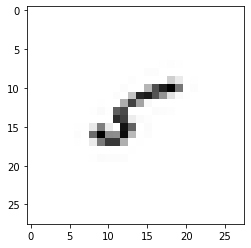

In [9]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

# iterating over 5 first data for user number0

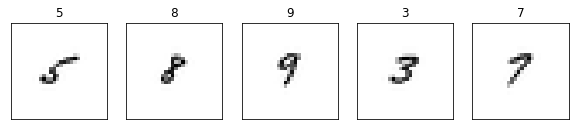

In [10]:
figure = plt.figure(figsize=(10, 2))
for i,x in enumerate(dataset_user_0.take(5)):
    
    plt.subplot(1,5,i+1)
    plt.imshow(x['pixels'].numpy(), cmap='gray', aspect='equal')
    plt.title(x['label'].numpy())
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    #_ = plt.show()

### Exploring heterogeneity in federated data

Federated data is typically non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), users typically have different distributions of data depending on usage patterns. Some clients may have fewer training examples on device, suffering from data paucity locally, while some clients will have more than enough training examples. Let's explore this concept of data heterogeneity typical of a federated system with the EMNIST data we have available. It's important to note that this deep analysis of a client's data is only available to us because this is a simulation environment where all the data is available to us locally. In a real production federated environment you would not be able to inspect a single client's data.

First, let's grab a sampling of one client's data to get a feel for the examples on one simulated device. Because the dataset we're using has been keyed by unique writer, the data of one client represents the handwriting of one person for a sample of the digits 0 through 9, simulating the unique "usage pattern" of one user.

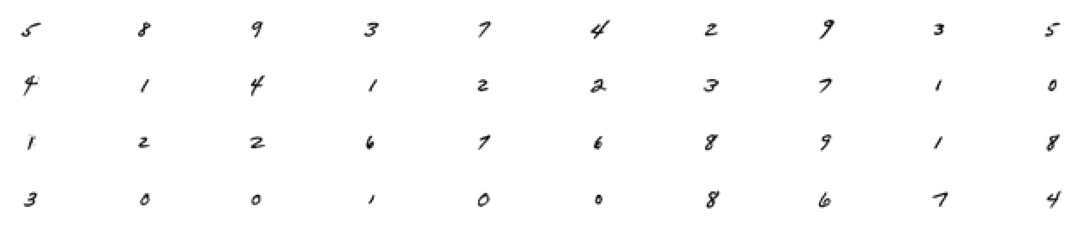

In [11]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in dataset_user_0.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

Now let's visualize the number of examples on each client for each MNIST digit label. In the federated environment, the number of examples on each client can vary quite a bit, depending on user behavior.

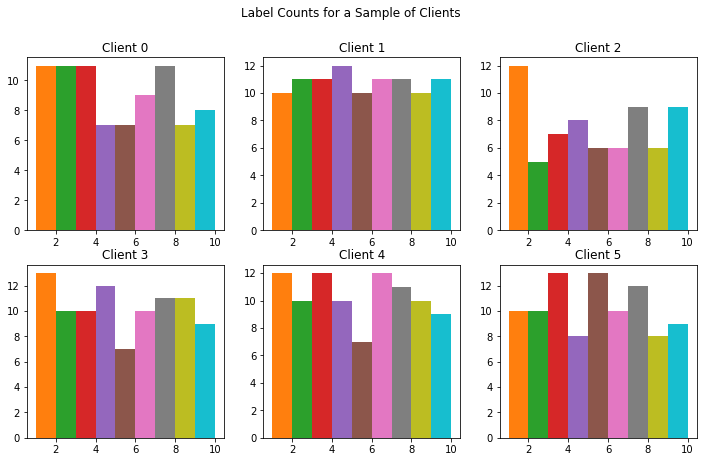

In [12]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=range(1,11))

Now let's visualize the mean image per client for each MNIST label. This code will produce the mean of each pixel value for all of the user's examples for one label. We'll see that one client's mean image for a digit will look different than another client's mean image for the same digit, due to each person's unique handwriting style. We can muse about how each local training round will nudge the model in a different direction on each client, as we're learning from that user's own unique data in that local round. Later in the tutorial we'll see how we can take each update to the model from all the clients and aggregate them together into our new global model, that has learned from each of our client's own unique data.

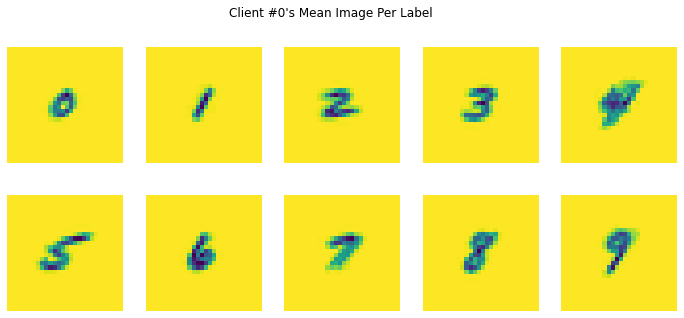

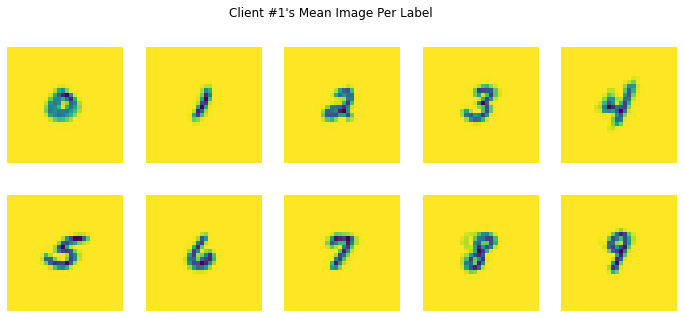

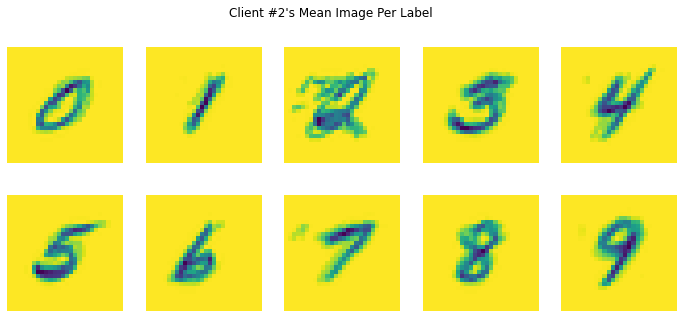

In [13]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(3): # mean over 3 users
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])

  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    label=example['label'].numpy()
    pixels=example['pixels'].numpy()
    plot_data[label].append(pixels)
    
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

User data can be noisy and unreliably labeled. For example, looking at Client #2's data above, we can see that for label 2, it is possible that there may have been some mislabeled examples creating a noisier mean image.

### Preprocessing the input data

Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations. Here, we flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and rename the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [14]:
#finding maximum number of data for all users
x=0;
for c_id in emnist_train.client_ids:
    val = len(emnist_train.create_tf_dataset_for_client(c_id))
    if(val>x):
        x=val
print(x)

132


In [15]:
NUM_CLIENTS = 30
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 28*28]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

Let's verify this worked.

In [16]:
preprocessed_example_dataset = preprocess(dataset_user_0)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[7],
                     [2],
                     [0],
                     [7],
                     [5],
                     [0],
                     [9],
                     [1],
                     [3],
                     [7],
                     [9],
                     [5],
                     [1],
                     [0],
                     [6],
                     [0],
                     [4],
                     [0],
                     [5],
                     [4]]))])

We have almost all the building blocks in place to construct federated data
sets.

One of the ways to feed federated data to TFF in a simulation is simply as a
Python list, with each element of the list holding the data of an individual
user, whether as a list or as a `tf.data.Dataset`. Since we already have
an interface that provides the latter, let's use it.

Here's a simple helper function that will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [17]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

Now, how do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very
large population of user devices, only a fraction of which may be available for
training at a given point in time. This is the case, for example, when the
client devices are mobile phones that participate in training only when plugged
into a power source, off a metered network, and otherwise idle.

Of course, we are in a simulation environment, and all the data is locally
available. Typically then, when running simulations, we would simply sample a
random subset of the clients to be involved in each round of training, generally
different in each round.

That said, as you can find out by studying the paper on the
[Federated Averaging](https://arxiv.org/abs/1602.05629) algorithm, achieving convergence in a system with randomly sampled
subsets of clients in each round can take a while, and it would be impractical
to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and
reuse the same set across rounds to speed up convergence (intentionally
over-fitting to these few user's data).

In [18]:
def give_sample_cilents(count):
    return np.random.choice(emnist_train.client_ids,count)
    
sample_clients = give_sample_cilents(NUM_CLIENTS)

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 30
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


## Creating a simple model with Keras

If you are using Keras, you likely already have code that constructs a Keras
model. Here's an example of a simple model that will suffice for our needs.

In [19]:
def create_keras_model():
  return tf.keras.models.Sequential([
      
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

**Note:** we do not compile the model yet. The loss, metrics, and optimizers are introduced later.

In order to use any model with TFF, it needs to be wrapped in an instance of the
`tff.learning.Model` interface, which exposes methods to stamp the model's
forward pass, metadata properties, etc., similarly to Keras, but also introduces
additional elements, such as ways to control the process of computing federated
metrics. Let's not worry about this for now; if you have a Keras model like the
one we've just defined above, you can have TFF wrap it for you by invoking
`tff.learning.from_keras_model`, passing the model and a sample data batch as
arguments, as shown below.

In [20]:
preprocessed_example_dataset.element_spec

OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)),
             ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])

In [21]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Training the model on federated data

Now that we have a model wrapped as `tff.learning.Model` for use with TFF, we
can let TFF construct a Federated Averaging algorithm by invoking the helper
function `tff.learning.build_federated_averaging_process`, as follows.

Keep in mind that the argument needs to be a constructor (such as `model_fn`
above), not an already-constructed instance, so that the construction of your
model can happen in a context controlled by TFF (if you're curious about the
reasons for this, we encourage you to read the follow-up tutorial on
[custom algorithms](custom_federated_algorithms_1.ipynb)).

One critical note on the Federated Averaging algorithm below, there are **2**
optimizers: a _client_optimizer_ and a _server_optimizer_. The
_client_optimizer_ is only used to compute local model updates on each client.
The _server_optimizer_ applies the averaged update to the global model at the
server. In particular, this means that the choice of optimizer and learning rate
used may need to be different than the ones you have used to train the model on
a standard i.i.d. dataset. We recommend starting with regular SGD, possibly with
a smaller learning rate than usual. The learning rate we use has not been
carefully tuned, feel free to experiment.

In [22]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

What just happened? TFF has constructed a pair of *federated computations* and
packaged them into a `tff.templates.IterativeProcess` in which these computations
are available as a pair of properties `initialize` and `next`.

In [23]:
iterative_process

In a nutshell, *federated computations* are programs in TFF's internal language
that can express various federated algorithms (you can find more about this in
the [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial). In this
case, the two computations generated and packed into `iterative_process`
implement [Federated Averaging](https://arxiv.org/abs/1602.05629).

It is a goal of TFF to define computations in a way that they could be executed
in real federated learning settings, but currently only local execution
simulation runtime is implemented. To execute a computation in a simulator, you
simply invoke it like a Python function. This default interpreted environment is
not designed for high performance, but it will suffice for this tutorial.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
Federated Averaging process on the server. While we don't want to dive into the
details of TFF, it may be instructive to see what this state looks like. You can
visualize it as follows.

In [24]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

While the above type signature may at first seem a bit cryptic, you can
recognize that the server state consists of a `model` (the initial model
parameters for MNIST that will be distributed to all devices), and
`optimizer_state` (additional information maintained by the server, such as the
number of rounds to use for hyperparameter schedules, etc.).

Let's invoke the `initialize` computation to construct the server state.

In [25]:
state = iterative_process.initialize()

The second of the pair of federated computations, `next`, represents a **single
round of Federated Averaging**, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [26]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.11910686), ('loss', 3.1075246)]))])


Let's run a few more rounds. As noted earlier, typically at this point you would
pick a subset of your simulation data from a new randomly selected sample of
users for each round in order to simulate a realistic deployment in which users
continuously come and go, but in this interactive notebook, for the sake of
demonstration we'll just reuse the same users, so that the system converges
quickly.

In [27]:
NUM_ROUNDS = 20
for round_num in range(2, NUM_ROUNDS):
  
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {0:2d}, metrics=(loss={2}/accuracy={1}'.format(round_num, metrics.get("train")["sparse_categorical_accuracy"],metrics.get("train")["loss"]))

round  2, metrics=(loss=2.972052812576294/accuracy=0.13110047578811646
round  3, metrics=(loss=2.874190330505371/accuracy=0.14347687363624573
round  4, metrics=(loss=2.8308959007263184/accuracy=0.1599999964237213
round  5, metrics=(loss=2.616349935531616/accuracy=0.1984688937664032
round  6, metrics=(loss=2.4877383708953857/accuracy=0.22494417428970337
round  7, metrics=(loss=2.3840298652648926/accuracy=0.22915470600128174
round  8, metrics=(loss=2.3188834190368652/accuracy=0.2655821442604065
round  9, metrics=(loss=2.2180588245391846/accuracy=0.2815949022769928
round 10, metrics=(loss=2.12312650680542/accuracy=0.3104306161403656
round 11, metrics=(loss=2.085867166519165/accuracy=0.3192344605922699
round 12, metrics=(loss=2.0082457065582275/accuracy=0.3461562991142273
round 13, metrics=(loss=1.916454553604126/accuracy=0.3754386007785797
round 14, metrics=(loss=1.8570830821990967/accuracy=0.4061881899833679
round 15, metrics=(loss=1.7726057767868042/accuracy=0.4236682653427124
round 16,

Training loss is decreasing after each round of federated training, indicating
the model is converging. There are some important caveats with these training
metrics, however, see the section on *Evaluation* later in this tutorial.

## Displaying model metrics in TensorBoard
Next, let's visualize the metrics from these federated computations using Tensorboard.

Let's start by creating the directory and the corresponding summary writer to write the metrics to.




In [28]:
#@test {"skip": true}
# use dir for windows
from platform import uname
import os
z=os.path.join("D:/","logs/scalars/training/")
x=(uname())[0]

if x!='Windows':
    print(1)
    logdir = "/tmp/logs/scalars/training/"
    !ls {logdir}
else:
    logdir = "D:/logs/scalars/training/"
    logdir = logdir.replace('/','\\')
    !dir {logdir}
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

 Volume in drive D is data
 Volume Serial Number is 7480-0583

 Directory of D:\logs\scalars\training

02/20/2021  05:27 PM    <DIR>          .
02/20/2021  05:27 PM    <DIR>          ..
01/07/2021  06:01 PM                40 events.out.tfevents.1610029917.ALI-PC.1076.37668.v2
01/07/2021  06:02 PM                40 events.out.tfevents.1610029953.ALI-PC.1076.37701.v2
01/07/2021  06:02 PM                40 events.out.tfevents.1610029972.ALI-PC.1076.37734.v2
01/07/2021  06:03 PM                40 events.out.tfevents.1610030033.ALI-PC.1076.37767.v2
01/07/2021  06:04 PM                40 events.out.tfevents.1610030051.ALI-PC.1076.37800.v2
01/07/2021  06:04 PM                40 events.out.tfevents.1610030061.ALI-PC.1076.37833.v2
01/07/2021  06:18 PM                40 events.out.tfevents.1610030903.ALI-PC.12088.23141.v2
01/07/2021  06:50 PM                40 events.out.tfevents.1610032816.ALI-PC.12088.23207.v2
01/07/2021  06:51 PM                40 events.out.tfevents.1610032902.ALI-PC.12088.2

Plot the relevant scalar metrics with the same summary writer

**this time we sample users randomly**

for completeness we added evaluation but it will be elabrated later more.

In [29]:
#@test {"skip": true}
evaluation = tff.learning.build_federated_evaluation(model_fn)
fed_train_results=[]
fed_test_results=[]
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    #sample_clients = give_sample_cilents(NUM_CLIENTS)
    federated_train_data = make_federated_data(emnist_train, sample_clients)
    state, metrics = iterative_process.next(state, federated_train_data)

    # Testing and trined
    sample_clients = give_sample_cilents(NUM_CLIENTS) # we sample again with the same number of users but not necessarily same users
    federated_test_data = make_federated_data(emnist_test, sample_clients)
    test_metrics_federated = evaluation(state.model, federated_test_data)
    fed_test_results.append(test_metrics_federated)
    fed_train_results.append(metrics)
    for name, value in metrics['train'].items():
      tf.summary.scalar(name, value, step=round_num)
    print('round {}/{}'.format(round_num+1, NUM_ROUNDS))

round 1/20
round 2/20
round 3/20
round 4/20
round 5/20
round 6/20
round 7/20
round 8/20
round 9/20
round 10/20
round 11/20
round 12/20
round 13/20
round 14/20
round 15/20
round 16/20
round 17/20
round 18/20
round 19/20


In [30]:
fed_test_results[-1]

OrderedDict([('sparse_categorical_accuracy', 0.68767124), ('loss', 1.2569522)])

Start TensorBoard with the root log directory specified above. It can take a few seconds for the data to load.

In [31]:
logdir

'D:\\logs\\scalars\\training\\'

In [32]:
#@test {"skip": true}

%tensorboard --logdir {logdir} --port=0

Reusing TensorBoard on port 6006 (pid 19316), started 0:45:04 ago. (Use '!kill 19316' to kill it.)

In [33]:
#@test {"skip": true}
# Uncomment and run this this cell to clean your directory of old output for
# future graphs from this directory. We don't run it by default so that if 
# you do a "Runtime > Run all" you don't lose your results.

#!rm -R /tmp/logs/scalars/*

In order to view evaluation metrics the same way, you can create a separate eval folder, like "logs/scalars/eval", to write to TensorBoard.

## Customizing the model implementation

Keras is the [recommended high-level model API for TensorFlow](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a), and we encourage using Keras models (via 
`tff.learning.from_keras_model`) in TFF whenever possible.

However, `tff.learning` provides a lower-level model interface, `tff.learning.Model`, that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks like `tf.keras.layers`) allows for maximum customization without modifying the internals of the federated learning algorithms.

So let's do it all over again from scratch.

### Defining model variables, forward pass, and metrics

The first step is to identify the TensorFlow variables we're going to work with.
In order to make the following code more legible, let's define a data structure
to represent the entire set. This will include variables such as `weights` and
`bias` that we will train, as well as variables that will hold various
cumulative statistics and counters we will update during training, such as
`loss_sum`, `accuracy_sum`, and `num_examples`.

In [34]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

Here's a method that creates the variables. For the sake of simplicity, we
represent all statistics as `tf.float32`, as that will eliminate the need for
type conversions at a later stage. Wrapping variable initializers as lambdas is
a requirement imposed by
[resource variables](https://www.tensorflow.org/api_docs/python/tf/enable_resource_variables).

In [35]:
def create_mnist_variables():
  return MnistVariables(
      weights=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False))

With the variables for model parameters and cumulative statistics in place, we
can now define the forward pass method that computes loss, emits predictions,
and updates the cumulative statistics for a single batch of input data, as
follows.

In [36]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

Next, we define a function that returns a set of local metrics, again using TensorFlow. These are the values (in addition to model updates, which are handled automatically) that are eligible to be aggregated to the server in a federated learning or evaluation process.

Here, we simply return the average `loss` and `accuracy`, as well as the
`num_examples`, which we'll need to correctly weight the contributions from
different users when computing federated aggregates.

In [37]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples)

Finally, we need to determine how to aggregate the local metrics emitted by each
device via `get_local_mnist_metrics`. This is the only part of the code that isn't written in TensorFlow  - it's a *federated computation* expressed in TFF. If you'd like to
dig deeper, skim over the [custom algorithms](custom_federated_algorithms_1.ipynb)
tutorial, but in most applications, you won't really need to; variants of the
pattern shown below should suffice. Here's what it looks like:


In [38]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return collections.OrderedDict(
      num_examples=tff.federated_sum(metrics.num_examples),
      loss=tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples))
  

The input `metrics` argument corresponds to the `OrderedDict` returned by `get_local_mnist_metrics` above, but critically the values are no longer `tf.Tensors` - they are "boxed" as `tff.Value`s, to make it clear you can no longer manipulate them using TensorFlow, but only using TFF's federated operators like `tff.federated_mean` and `tff.federated_sum`.  The returned
dictionary of global aggregates defines the set of metrics which will be available on the server.




### Constructing an instance of `tff.learning.Model`

With all of the above in place, we are ready to construct a model representation
for use with TFF similar to one that's generated for you when you let TFF ingest
a Keras model.

In [39]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 784], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32))

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_exmaples)

  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

As you can see, the abstract methods and properties defined by
`tff.learning.Model` corresponds to the code snippets in the preceding section
that introduced the variables and defined the loss and statistics.

Here are a few points worth highlighting:

*   All state that your model will use must be captured as TensorFlow variables,
    as TFF does not use Python at runtime (remember your code should be written
    such that it can be deployed to mobile devices; see the
    [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial for a more
    in-depth commentary on the reasons).
*   Your model should describe what form of data it accepts (`input_spec`), as
    in general, TFF is a strongly-typed environment and wants to determine type
    signatures for all components. Declaring the format of your model's input is
    an essential part of it.
*   Although technically not required, we recommend wrapping all TensorFlow
    logic (forward pass, metric calculations, etc.) as `tf.function`s,
    as this helps ensure the TensorFlow can be serialized, and removes the need
    for explicit control dependencies.


The above is sufficient for evaluation and algorithms like Federated SGD.
However, for Federated Averaging, we need to specify how the model should train
locally on each batch. We will specify a local optimizer when building the Federated Averaging algorithm.

### Simulating federated training with the new model

With all the above in place, the remainder of the process looks like what we've
seen already - just replace the model constructor with the constructor of our
new model class, and use the two federated computations in the iterative process
you created to cycle through training rounds.

In [40]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistModel,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))

In [41]:
state = iterative_process.initialize()

In [42]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 15050.0), ('loss', 3.0416937), ('accuracy', 0.11800665)]))])


In [43]:
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 15050.0), ('loss', 2.955605), ('accuracy', 0.14066446)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 15050.0), ('loss', 2.8744311), ('accuracy', 0.1433887)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 15050.0), ('loss', 2.7130654), ('accuracy', 0.16990033)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 15050.0), ('loss', 2.6111574), ('accuracy', 0.18784054)]))])
round  6, metrics=OrderedDict([('broadcast', ()), 

To see these metrics within TensorBoard, refer to the steps listed above in "Displaying model metrics in TensorBoard".

## Evaluation

All of our experiments so far presented only federated training metrics - the
average metrics over all batches of data trained across all clients in the
round. This introduces the normal concerns about overfitting, especially since
we used the same set of clients on each round for simplicity, but there is an
additional notion of overfitting in training metrics specific to the Federated
Averaging algorithm. This is easiest to see if we imagine each client had a
single batch of data, and we train on that batch for many iterations (epochs).
In this case, the local model will quickly exactly fit to that one batch, and so
the local accuracy metric we average will approach 1.0. Thus, these training
metrics can be taken as a sign that training is progressing, but not much more.

To perform evaluation on federated data, you can construct another *federated
computation* designed for just this purpose, using the
`tff.learning.build_federated_evaluation` function, and passing in your model
constructor as an argument. Note that unlike with Federated Averaging, where
we've used `MnistTrainableModel`, it suffices to pass the `MnistModel`.
Evaluation doesn't perform gradient descent, and there's no need to construct
optimizers.

For experimentation and research, when a centralized test dataset is available,
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb)
demonstrates another evaluation option: taking the trained weights from
federated learning, applying them to a standard Keras model, and then simply
calling `tf.keras.models.Model.evaluate()` on a centralized dataset.

In [44]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

You can inspect the abstract type signature of the evaluation function as follows.

In [45]:
str(evaluation.type_signature)

'(<server_model_weights=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,federated_dataset={<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <num_examples=float32@SERVER,loss=float32@SERVER,accuracy=float32@SERVER>)'

No need to be concerned about the details at this point, just be aware that it
takes the following general form, similar to `tff.templates.IterativeProcess.next`
but with two important differences. First, we are not returning server state,
since evaluation doesn't modify the model or any other aspect of state - you can
think of it as stateless. Second, evaluation only needs the model, and doesn't
require any other part of server state that might be associated with training,
such as optimizer variables.

```
SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS
```

Let's invoke evaluation on the latest state we arrived at during training. In
order to extract the latest trained model from the server state, you simply
access the `.model` member, as follows.

In [46]:
train_metrics = evaluation(state.model, federated_train_data)

Here's what we get. Note the numbers look marginally better than what was
reported by the last round of training above. By convention, the training
metrics reported by the iterative training process generally reflect the
performance of the model at the beginning of the training round, so the
evaluation metrics will always be one step ahead.

In [47]:
str(train_metrics)

"OrderedDict([('num_examples', 15050.0), ('loss', 1.5575413), ('accuracy', 0.64152825)])"

Now, let's compile a test sample of federated data and rerun evaluation on the
test data. The data will come from the same sample of real users, but from a
distinct held-out data set.

In [48]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(30,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [49]:
test_metrics = evaluation(state.model, federated_test_data)

In [50]:
str(test_metrics)

"OrderedDict([('num_examples', 1825.0), ('loss', 1.60109), ('accuracy', 0.5972603)])"

This concludes the tutorial. We encourage you to play with the
parameters (e.g., batch sizes, number of users, epochs, learning rates, etc.), to modify the code above to simulate training on random samples of users in
each round, and to explore the other tutorials we've developed.

**A Comparison to the old fashion method**
In this section we are going to make a simple nn (with exactly the same architecture and hyperparameters) and train as all data is available(centralized learning)

Let's compare accuracy to a simple nn with a central learning

In [133]:
def preprocess_no_repeat(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 28*28]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

def make_federated_data_no_repeat(client_data, client_ids):
  return [
      preprocess_no_repeat(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]


In [134]:
full_federated_train_data = make_federated_data_no_repeat(emnist_train, give_sample_cilents(NUM_CLIENTS))
full_federated_test_data = make_federated_data_no_repeat(emnist_test, give_sample_cilents(NUM_CLIENTS))

In [140]:
try:
    del train_images, train_labels
except:
    pass
i=1
f=0
for cl_data in full_federated_train_data:
    
    for data in cl_data:
        try:
          train_labels = np.append(train_labels, data['y'], axis=0)
          train_images = np.append(train_images, data['x'], axis=0)

        except:
          train_labels = np.array(data['y'])
          train_images = np.array(data['x'])

    if i%10==0:
        print("{}/{}".format(i,len(full_federated_train_data)))
    i=i+1

10/30
20/30
30/30


In [141]:
print(train_labels.shape)
print(len(train_images))

(3157, 1)
3157


In [142]:
d=next(iter(full_federated_test_data[0]))
#train_labels = np.array(data['y'])
#train_labels = np.append(train_labels, data['y'],axis=0)

In [143]:
f=1
i=1
try:
    del test_labels, test_images

for cl_data in full_federated_test_data:
  for data in cl_data:
    if(f):
      test_labels = np.array(data['y'])
      test_images = np.array(data['x'])
      f=0
    else:  
      test_labels= np.append(test_labels, data['y'].numpy(), axis=0)
      test_images= np.append(test_images, data['x'].numpy(), axis=0)
   
  if(i%10==0):
    print("{}/{}".format(i,len(full_federated_test_data)))
  i=i+1

10/30
20/30
30/30


In [144]:
centralized_model = create_keras_model()

centralized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

#!rm -rf ./logs/
log_dir2 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)


In [145]:
res=centralized_model.fit(train_images, train_labels, epochs=NUM_ROUNDS, shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/20
 2/99 [..............................] - ETA: 15s - loss: 2.4522 - sparse_categorical_accuracy: 0.0625WARNING:tensorflow:Callbacks method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_begin` time: 0.0120s). Check your callbacks.


99/99 [==============================] - 0s 4ms/step - loss: 2.2213 - sparse_categorical_accuracy: 0.1973
Epoch 2/20
99/99 [==============================] - 0s 1ms/step - loss: 1.9198 - sparse_categorical_accuracy: 0.4203
Epoch 3/20
99/99 [==============================] - 0s 1ms/step - loss: 1.7004 - sparse_categorical_accuracy: 0.5258
Epoch 4/20
99/99 [==============================] - 0s 1ms/step - loss: 1.5228 - sparse_categorical_accuracy: 0.6094
Epoch 5/20
99/99 [==============================] - 0s 1ms/step - loss: 1.3706 - sparse_categorical_accuracy: 0.6734
Epoch 6/20
99/99 [==============================] - 0s 1ms/step - loss: 1.2602 - sparse_categorical_accuracy: 0.6959
Epoch 7/20
99/99 [==============================] - 0s 1ms/step - loss: 1.1628 - sparse_categorical_accuracy: 0.7285
Epoch 8/20
99/99 [==============================] - 0s 1ms/step - loss: 1.0921 - sparse_categorical_accuracy: 0.7460
Epoch 9/20
99/99 [==============================] - 0s 1ms/step - loss: 1.0

In [146]:

test_results_normal = centralized_model.evaluate(test_images,  test_labels, verbose=2)


57/57 - 0s - loss: 0.7936 - sparse_categorical_accuracy: 0.7912


In [147]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16772), started 1:04:49 ago. (Use '!kill 16772' to kill it.)

In [148]:
federated_loss_train = [ x['train']['loss'] for x in fed_train_results]
federated_loss_train.append(federated_loss_train[-1])  # to be same size
federated_loss_test = [ x['loss'] for x in fed_test_results]
federated_accuracy_train = [ x['train']['sparse_categorical_accuracy'] for x in fed_train_results]
federated_accuracy_test = [ x['sparse_categorical_accuracy'] for x in fed_test_results]

In [149]:
normal_loss=res.history['loss']
normal_accuracy=res.history['sparse_categorical_accuracy']

In [150]:
for x in fed_test_results:
  print(x['sparse_categorical_accuracy'])


0.36147758
0.24444444
0.50274724
0.075675674
0.5316092
0.42857143
0.5540541
0.5849057
0.48369566
0.6473829
0.67403316
0.5833333
0.61333334
0.6502732
0.69945353
0.67582417
0.7005494
0.71944445
0.68767124


<ipython-input-151-621db1876a50>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(federated_accuracy_train, Label=r'$Federated_{ Accuracy}$')
<ipython-input-151-621db1876a50>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(normal_accuracy, Label=r'$Normal_{ Accuracy}$')


Final Accuracy: fed=(0.6877)  VS normal=(0.7912)


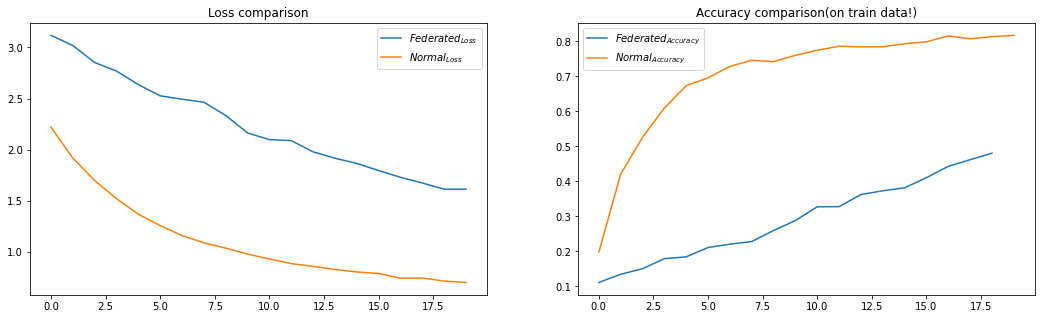

In [151]:
figure = plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(federated_loss_train,label=r'$Federated_{ Loss}$')
plt.plot(normal_loss,label=r'$Normal_{ Loss}$')
plt.legend()
plt.title("Loss comparison")
plt.subplot(1,2,2)
plt.plot(federated_accuracy_train, Label=r'$Federated_{ Accuracy}$')
plt.plot(normal_accuracy, Label=r'$Normal_{ Accuracy}$')
plt.title("Accuracy comparison(on train data!)")
print("Final Accuracy: fed=({:.4f})  VS normal=({:.4f})".format(federated_accuracy_test[-1],test_results_normal[1]))

l=plt.legend()

** one sample output **
As we have dicussed above we could arrive to the same accuracy on test data (in comparison to centrilized training)
but with a one **big assumptiom**:

we always access specified devices and won't sample clients per itteration. if you run this notebook with code below you can see the difference.

``` python
sample_clients = give_sample_cilents(NUM_CLIENTS)
```
if we do not sample evey time we will have these results:

Final Accuracy: fed=(0.7895)  VS normal=(0.7304)

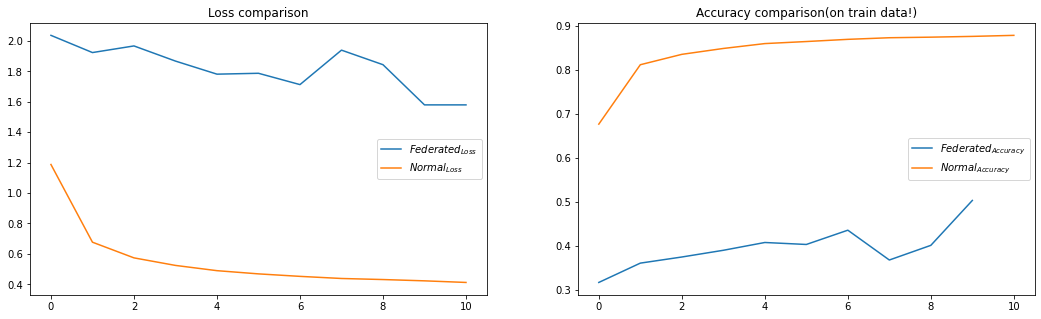

so what should we do?

I think our scaling and iterations used in this notebook are quiet low. if we increase these parameters, we will have much better results.(with the cost of high computation.....)
we should consider a note. We are trying to simluate a task which is done by collaborative work of thousands nodes(or even millions!) so, I guess we must expect this simulation to be at a high-computational-cost level especially due to lack of gpu accelerated availability in TFF. (4 January 2021)


# A test

In [105]:
from scipy import io as spio
emnist = spio.loadmat("D:\\db\\emnist-digits.mat")

In [114]:
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

# normalize
x_train = x_train/ 255
x_test = x_test / 255

In [117]:
x_train[0].shape

(784,)

[9]


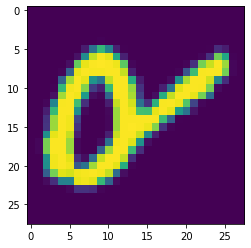

In [124]:
plt.imshow(np.reshape(x_train[1],[28,28]))
print(y_train[1])

In [70]:
centralized_model2 = create_keras_model()

centralized_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

#!rm -rf ./logs/
log_dir2 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)


In [129]:
res2=centralized_model.fit(x_train, y_train, epochs=NUM_ROUNDS, shuffle=True, callbacks=[tensorboard_callback], validation_data=(x_test, y_test))

Epoch 1/20
   2/7500 [..............................] - ETA: 17:26 - loss: 25.8736 - sparse_categorical_accuracy: 0.1406WARNING:tensorflow:Callbacks method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0030s vs `on_train_batch_begin` time: 0.0110s). Check your callbacks.


7500/7500 [==============================] - 11s 1ms/step - loss: 1.1865 - sparse_categorical_accuracy: 0.8295 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.9203
Epoch 2/20
7500/7500 [==============================] - 11s 1ms/step - loss: 0.2904 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.2611 - val_sparse_categorical_accuracy: 0.9325
Epoch 3/20
7500/7500 [==============================] - 11s 2ms/step - loss: 0.2479 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.2370 - val_sparse_categorical_accuracy: 0.9377
Epoch 4/20
7500/7500 [==============================] - 11s 2ms/step - loss: 0.2352 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.2332 - val_sparse_categorical_accuracy: 0.9380
Epoch 5/20
7500/7500 [==============================] - 11s 1ms/step - loss: 0.2289 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.2262 - val_sparse_categorical_accuracy: 0.9401
Epoch 6/20
7500/7500 [==============================] - 11s 1ms/step - loss: 0.2253 - sparse_cat

In [130]:
normal_loss2=res2.history['loss']
normal_accuracy2=res2.history['sparse_categorical_accuracy']

<ipython-input-131-22ba1a0a2359>:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(normal_loss2, Label="emnist")
<ipython-input-131-22ba1a0a2359>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(normal_loss, Label="cumulated orginal emnist")


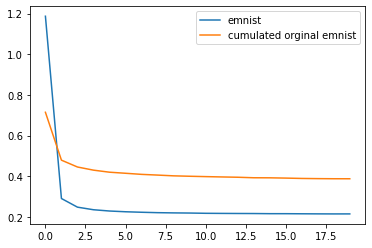

In [131]:
plt.plot(normal_loss2, Label="emnist")
plt.plot(normal_loss, Label="cumulated orginal emnist")
plt.legend()

<ipython-input-132-ba82fd728069>:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(normal_accuracy2, Label="emnist")
<ipython-input-132-ba82fd728069>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(normal_accuracy, Label="cumulated orginal emnist")


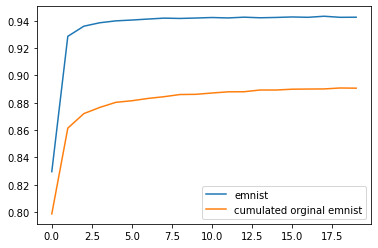

In [132]:
plt.plot(normal_accuracy2, Label="emnist")
plt.plot(normal_accuracy, Label="cumulated orginal emnist")
plt.legend()